# Experiment 22: Attention Patterns & Task Analysis

**Date:** 2025-02-05

## Motivation

Experiment 21 showed that query-in-context (B) ≈ bare (A), meaning document tokens attending
to query tokens during encoding doesn't help. This experiment investigates WHY.

## Three Investigations

### Part 1: Attention Pattern Analysis
Do document tokens actually attend to query tokens? If attention weights are near-zero,
that explains why there's no benefit.

### Part 2: Prefix LM Comparison
Exp 09 used ChatGLM-6B (prefix LM) and found irrelevant priming beats oracle.
We'll verify this with a cleaner setup and understand why.

### Part 3: Task Where Context-Dependence Matters
Test tasks where the answer REQUIRES synthesizing query + document:
- Conditional generation ("describe X in the style of Y")
- Slot filling ("find the [ENTITY] that [RELATION]")
- Comparative QA ("how does X compare to Y according to the passage?")

In [1]:
# Cell 1: Setup
import os
os.umask(0o000)

import sys
sys.path.insert(0, '/home/jupyter/research/directed_kvcache')

import json
import random
import numpy as np
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Optional
from scipy import stats
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DynamicCache
from datasets import load_dataset

from lib.kv_cache import (
    deepcopy_cache,
    _get_cache_keys,
    _get_cache_values,
    _ensure_dynamic_cache,
    extract_and_truncate_cache_with_bos,
    correct_rope_positions_with_bos,
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

OUTPUT_DIR = '/home/jupyter/research/directed_kvcache/results/exp22'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

PyTorch: 2.10.0+cu128
CUDA: True


In [2]:
# Cell 2: Load Model (with attention output enabled)
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    attn_implementation="eager",  # Need eager for attention weights
)
model.eval()

print(f"Model loaded on {model.device}")
print(f"Attention implementation: eager (for attention weight extraction)")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded on cuda:0
Attention implementation: eager (for attention weight extraction)


---
## Part 1: Attention Pattern Analysis

**Question:** When we encode `[query + document]`, how much do document tokens attend to query tokens?

If document tokens barely attend to query tokens, then having the query in context doesn't
actually influence the document representations much — explaining why B ≈ A in Exp 21.

In [3]:
# Cell 4: Extract Attention Patterns

def get_attention_weights(text: str) -> Tuple[torch.Tensor, List[str]]:
    """
    Get attention weights for all layers and heads.
    
    Returns:
        attention: [n_layers, n_heads, seq_len, seq_len]
        tokens: List of token strings
    """
    inputs = tokenizer(text, return_tensors='pt').to(model.device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    with torch.no_grad():
        outputs = model(
            **inputs,
            output_attentions=True,
            return_dict=True
        )
    
    # Stack attention from all layers: [n_layers, batch, n_heads, seq, seq]
    attention = torch.stack(outputs.attentions)[:, 0, :, :, :]  # Remove batch dim
    
    return attention, tokens


def analyze_query_document_attention(query: str, doc: str):
    """
    Analyze how much document tokens attend to query tokens.
    """
    full_text = query + " " + doc
    
    # Get token boundaries
    query_ids = tokenizer.encode(query + " ", add_special_tokens=True)
    query_len = len(query_ids)  # includes BOS
    
    full_ids = tokenizer.encode(full_text, add_special_tokens=True)
    full_len = len(full_ids)
    doc_start = query_len
    doc_len = full_len - query_len
    
    # Get attention weights
    attention, tokens = get_attention_weights(full_text)
    n_layers, n_heads, seq_len, _ = attention.shape
    
    print(f"Sequence: {seq_len} tokens")
    print(f"Query: tokens 0-{query_len-1} ({query_len} tokens)")
    print(f"Document: tokens {doc_start}-{seq_len-1} ({doc_len} tokens)")
    print()
    
    # For each document token, compute attention to query vs attention to other doc tokens
    results = {
        'attn_to_query': [],  # [n_layers, n_heads, doc_len]
        'attn_to_doc': [],
        'attn_to_bos': [],
    }
    
    for layer in range(n_layers):
        layer_attn_to_query = []
        layer_attn_to_doc = []
        layer_attn_to_bos = []
        
        for head in range(n_heads):
            # For document tokens (positions doc_start to seq_len-1)
            # Sum attention to query region (positions 1 to query_len-1, excluding BOS)
            doc_attn = attention[layer, head, doc_start:, :]  # [doc_len, seq_len]
            
            attn_to_bos = doc_attn[:, 0].mean().item()  # Attention to BOS
            attn_to_query = doc_attn[:, 1:query_len].sum(dim=1).mean().item()  # Attention to query
            attn_to_doc = doc_attn[:, doc_start:].sum(dim=1).mean().item()  # Attention to other doc tokens
            
            layer_attn_to_query.append(attn_to_query)
            layer_attn_to_doc.append(attn_to_doc)
            layer_attn_to_bos.append(attn_to_bos)
        
        results['attn_to_query'].append(layer_attn_to_query)
        results['attn_to_doc'].append(layer_attn_to_doc)
        results['attn_to_bos'].append(layer_attn_to_bos)
    
    # Convert to numpy for analysis
    for key in results:
        results[key] = np.array(results[key])  # [n_layers, n_heads]
    
    return results, tokens, query_len

print("Attention analysis functions defined.")

Attention analysis functions defined.


In [4]:
# Cell 5: Run Attention Analysis on Example

print("="*70)
print("ATTENTION PATTERN ANALYSIS")
print("="*70)

# Simple example
query = "What is the capital of France?"
doc = "Paris is the capital and largest city of France. It is known for the Eiffel Tower and the Louvre Museum."

print(f"\nQuery: {query}")
print(f"Document: {doc}")
print()

results, tokens, query_len = analyze_query_document_attention(query, doc)

# Aggregate across heads
mean_attn_to_query = results['attn_to_query'].mean(axis=1)  # [n_layers]
mean_attn_to_doc = results['attn_to_doc'].mean(axis=1)
mean_attn_to_bos = results['attn_to_bos'].mean(axis=1)

print("\nMean attention from document tokens (averaged across heads):")
print("-" * 60)
print(f"{'Layer':<8} {'To BOS':<12} {'To Query':<12} {'To Doc':<12} {'Query %':<10}")
print("-" * 60)

for layer in [0, 7, 15, 23, 31]:  # Sample layers
    total = mean_attn_to_bos[layer] + mean_attn_to_query[layer] + mean_attn_to_doc[layer]
    query_pct = mean_attn_to_query[layer] / total * 100 if total > 0 else 0
    print(f"{layer:<8} {mean_attn_to_bos[layer]:<12.4f} {mean_attn_to_query[layer]:<12.4f} {mean_attn_to_doc[layer]:<12.4f} {query_pct:<10.1f}%")

print("\n" + "-" * 60)
print(f"Overall mean attention to query: {mean_attn_to_query.mean():.4f}")
print(f"Overall mean attention to doc: {mean_attn_to_doc.mean():.4f}")
print(f"Ratio (query/doc): {mean_attn_to_query.mean() / mean_attn_to_doc.mean():.4f}")

ATTENTION PATTERN ANALYSIS

Query: What is the capital of France?
Document: Paris is the capital and largest city of France. It is known for the Eiffel Tower and the Louvre Museum.

Sequence: 33 tokens
Query: tokens 0-8 (9 tokens)
Document: tokens 9-32 (24 tokens)


Mean attention from document tokens (averaged across heads):
------------------------------------------------------------
Layer    To BOS       To Query     To Doc       Query %   
------------------------------------------------------------
0        0.6604       0.1036       0.2361       10.4      %
7        0.7796       0.0858       0.1351       8.6       %
15       0.7069       0.1251       0.1681       12.5      %
23       0.8159       0.0378       0.1460       3.8       %
31       0.5552       0.1022       0.3427       10.2      %

------------------------------------------------------------
Overall mean attention to query: 0.0775
Overall mean attention to doc: 0.1803
Ratio (query/doc): 0.4300


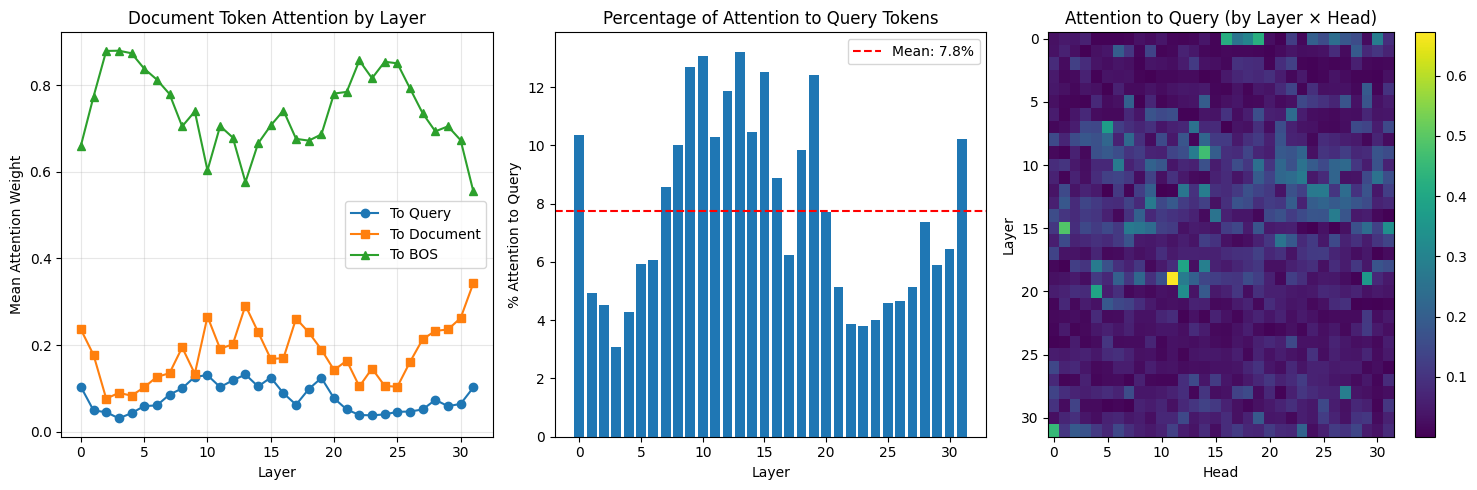


Figure saved to /home/jupyter/research/directed_kvcache/results/exp22/attention_pattern.png


In [5]:
# Cell 6: Visualize Attention Pattern

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Attention to query across layers
ax1 = axes[0]
ax1.plot(mean_attn_to_query, label='To Query', marker='o')
ax1.plot(mean_attn_to_doc, label='To Document', marker='s')
ax1.plot(mean_attn_to_bos, label='To BOS', marker='^')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Mean Attention Weight')
ax1.set_title('Document Token Attention by Layer')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Query attention as percentage
ax2 = axes[1]
total = mean_attn_to_bos + mean_attn_to_query + mean_attn_to_doc
query_pct = mean_attn_to_query / total * 100
ax2.bar(range(len(query_pct)), query_pct)
ax2.set_xlabel('Layer')
ax2.set_ylabel('% Attention to Query')
ax2.set_title('Percentage of Attention to Query Tokens')
ax2.axhline(y=query_pct.mean(), color='r', linestyle='--', label=f'Mean: {query_pct.mean():.1f}%')
ax2.legend()

# Plot 3: Heatmap of attention to query by layer and head
ax3 = axes[2]
im = ax3.imshow(results['attn_to_query'], aspect='auto', cmap='viridis')
ax3.set_xlabel('Head')
ax3.set_ylabel('Layer')
ax3.set_title('Attention to Query (by Layer × Head)')
plt.colorbar(im, ax=ax3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/attention_pattern.png', dpi=150)
plt.show()

print(f"\nFigure saved to {OUTPUT_DIR}/attention_pattern.png")

In [6]:
# Cell 7: Multiple Examples

print("\n" + "="*70)
print("ATTENTION ANALYSIS ACROSS MULTIPLE EXAMPLES")
print("="*70)

examples = [
    ("What is the capital of France?", 
     "Paris is the capital and largest city of France."),
    ("Who invented the telephone?",
     "Alexander Graham Bell is credited with inventing the first practical telephone in 1876."),
    ("What is photosynthesis?",
     "Photosynthesis is the process by which plants convert sunlight into chemical energy, producing oxygen and glucose from carbon dioxide and water."),
    ("How tall is Mount Everest?",
     "Mount Everest is the highest mountain on Earth, with a peak at 8,849 meters above sea level."),
    ("What causes rain?",
     "Rain occurs when water vapor in the atmosphere condenses into droplets that become heavy enough to fall to the ground.")
]

all_query_attn = []

for query, doc in examples:
    results, _, _ = analyze_query_document_attention(query, doc)
    mean_attn = results['attn_to_query'].mean()  # Overall mean
    all_query_attn.append(mean_attn)
    print(f"Query: '{query[:40]}...' -> Mean attn to query: {mean_attn:.4f}")

print(f"\nOverall mean attention to query: {np.mean(all_query_attn):.4f}")
print(f"Standard deviation: {np.std(all_query_attn):.4f}")


ATTENTION ANALYSIS ACROSS MULTIPLE EXAMPLES
Sequence: 18 tokens
Query: tokens 0-8 (9 tokens)
Document: tokens 9-17 (9 tokens)

Query: 'What is the capital of France?...' -> Mean attn to query: 0.1257
Sequence: 26 tokens
Query: tokens 0-6 (7 tokens)
Document: tokens 7-25 (19 tokens)

Query: 'Who invented the telephone?...' -> Mean attn to query: 0.0815
Sequence: 39 tokens
Query: tokens 0-8 (9 tokens)
Document: tokens 9-38 (30 tokens)

Query: 'What is photosynthesis?...' -> Mean attn to query: 0.0594
Sequence: 33 tokens
Query: tokens 0-8 (9 tokens)
Document: tokens 9-32 (24 tokens)

Query: 'How tall is Mount Everest?...' -> Mean attn to query: 0.0819
Sequence: 30 tokens
Query: tokens 0-5 (6 tokens)
Document: tokens 6-29 (24 tokens)

Query: 'What causes rain?...' -> Mean attn to query: 0.0545

Overall mean attention to query: 0.0806
Standard deviation: 0.0252


---
## Part 2: Task Where Context-Dependence Matters

MS MARCO factoid QA may be too "easy" — the document contains the answer regardless of query.
Let's test tasks where the answer genuinely depends on query-document interaction.

### Task: Comparative QA
Given a passage comparing multiple entities, answer questions that require identifying
the right entity based on the query. The document alone is ambiguous without the query.

In [7]:
# Cell 9: Comparative QA Task

print("="*70)
print("COMPARATIVE QA TASK")
print("="*70)

# Create samples where the document describes multiple entities
# and the query determines which one to focus on

comparative_samples = [
    {
        'doc': "Apple Inc. was founded in 1976 and is headquartered in Cupertino. Microsoft was founded in 1975 and is headquartered in Redmond. Google was founded in 1998 and is headquartered in Mountain View.",
        'query': "When was Apple founded?",
        'answer': "1976",
        'distractor_query': "When was Microsoft founded?",
        'distractor_answer': "1975",
    },
    {
        'doc': "The Nile is 6,650 km long and flows through northeastern Africa. The Amazon is 6,400 km long and flows through South America. The Yangtze is 6,300 km long and flows through China.",
        'query': "How long is the Amazon river?",
        'answer': "6,400 km",
        'distractor_query': "How long is the Nile?",
        'distractor_answer': "6,650 km",
    },
    {
        'doc': "Einstein developed the theory of relativity. Newton formulated the laws of motion. Darwin proposed the theory of evolution by natural selection.",
        'query': "What did Newton formulate?",
        'answer': "laws of motion",
        'distractor_query': "What did Einstein develop?",
        'distractor_answer': "theory of relativity",
    },
    {
        'doc': "Python was created by Guido van Rossum in 1991. JavaScript was created by Brendan Eich in 1995. Ruby was created by Yukihiro Matsumoto in 1995.",
        'query': "Who created JavaScript?",
        'answer': "Brendan Eich",
        'distractor_query': "Who created Python?",
        'distractor_answer': "Guido van Rossum",
    },
    {
        'doc': "Tokyo has a population of 14 million. Delhi has a population of 32 million. Shanghai has a population of 29 million.",
        'query': "What is the population of Shanghai?",
        'answer': "29 million",
        'distractor_query': "What is the population of Delhi?",
        'distractor_answer': "32 million",
    },
]

print(f"Created {len(comparative_samples)} comparative QA samples")
print(f"\nExample:")
print(f"  Document: {comparative_samples[0]['doc']}")
print(f"  Query: {comparative_samples[0]['query']}")
print(f"  Answer: {comparative_samples[0]['answer']}")
print(f"  Distractor Query: {comparative_samples[0]['distractor_query']}")
print(f"  Distractor Answer: {comparative_samples[0]['distractor_answer']}")

COMPARATIVE QA TASK
Created 5 comparative QA samples

Example:
  Document: Apple Inc. was founded in 1976 and is headquartered in Cupertino. Microsoft was founded in 1975 and is headquartered in Redmond. Google was founded in 1998 and is headquartered in Mountain View.
  Query: When was Apple founded?
  Answer: 1976
  Distractor Query: When was Microsoft founded?
  Distractor Answer: 1975


In [8]:
# Cell 10: Test Comparative QA with Different Cache Conditions

def score_answer_nll(cache, prompt: str, answer: str) -> float:
    """Score P(answer | cache, prompt)."""
    cache = _ensure_dynamic_cache(cache)
    cache_len = _get_cache_keys(cache, 0).shape[2]
    
    prompt_ids = tokenizer.encode(prompt, return_tensors='pt', add_special_tokens=False).to(model.device)
    answer_ids = tokenizer.encode(answer, return_tensors='pt', add_special_tokens=False).to(model.device)
    
    input_ids = torch.cat([prompt_ids, answer_ids], dim=1)
    total_len = cache_len + input_ids.shape[1]
    attention_mask = torch.ones((1, total_len), device=model.device)
    
    cache_copy = deepcopy_cache(cache)
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            past_key_values=cache_copy,
            use_cache=True,
            return_dict=True
        )
    
    logits = outputs.logits
    prompt_len = prompt_ids.shape[1]
    answer_len = answer_ids.shape[1]
    
    if answer_len == 0:
        return 0.0
    
    answer_logits = logits[:, prompt_len-1:prompt_len+answer_len-1, :]
    loss_fct = torch.nn.CrossEntropyLoss(reduction='mean')
    loss = loss_fct(answer_logits.view(-1, answer_logits.size(-1)), answer_ids.view(-1))
    
    return loss.item()


def build_bare_cache(text: str):
    ids = tokenizer.encode(text, return_tensors='pt', add_special_tokens=True).to(model.device)
    with torch.no_grad():
        out = model(ids, use_cache=True)
    return _ensure_dynamic_cache(out.past_key_values)


def build_full_context_cache(query: str, doc: str):
    full_text = query + " " + doc
    ids = tokenizer.encode(full_text, return_tensors='pt', add_special_tokens=True).to(model.device)
    with torch.no_grad():
        out = model(ids, use_cache=True)
    return _ensure_dynamic_cache(out.past_key_values)


print("\n" + "-"*70)
print("COMPARATIVE QA: Does query-priming help when document is ambiguous?")
print("-"*70)

results_comparative = []

for i, sample in enumerate(comparative_samples):
    doc = sample['doc']
    query = sample['query']
    answer = " " + sample['answer']
    distractor_query = sample['distractor_query']
    distractor_answer = " " + sample['distractor_answer']
    
    # Condition A: Bare document cache, query at scoring
    cache_A = build_bare_cache(doc)
    prompt_A = f"\n\nQuestion: {query}\nAnswer:"
    nll_A_correct = score_answer_nll(cache_A, prompt_A, answer)
    nll_A_distractor = score_answer_nll(cache_A, prompt_A, distractor_answer)
    
    # Condition B: Full context (query + doc), no query repeat
    cache_B = build_full_context_cache(query, doc)
    prompt_B = "\n\nAnswer:"
    nll_B_correct = score_answer_nll(cache_B, prompt_B, answer)
    nll_B_distractor = score_answer_nll(cache_B, prompt_B, distractor_answer)
    
    # Condition C: Full context with WRONG query priming
    cache_C = build_full_context_cache(distractor_query, doc)
    nll_C_correct = score_answer_nll(cache_C, prompt_B, answer)
    nll_C_distractor = score_answer_nll(cache_C, prompt_B, distractor_answer)
    
    results_comparative.append({
        'A_correct': nll_A_correct,
        'A_distractor': nll_A_distractor,
        'B_correct': nll_B_correct,
        'B_distractor': nll_B_distractor,
        'C_correct': nll_C_correct,
        'C_distractor': nll_C_distractor,
    })
    
    print(f"\nSample {i+1}: {query}")
    print(f"  A (bare):       correct={nll_A_correct:.3f}, distractor={nll_A_distractor:.3f}, gap={nll_A_distractor-nll_A_correct:+.3f}")
    print(f"  B (oracle q):   correct={nll_B_correct:.3f}, distractor={nll_B_distractor:.3f}, gap={nll_B_distractor-nll_B_correct:+.3f}")
    print(f"  C (wrong q):    correct={nll_C_correct:.3f}, distractor={nll_C_distractor:.3f}, gap={nll_C_distractor-nll_C_correct:+.3f}")


----------------------------------------------------------------------
COMPARATIVE QA: Does query-priming help when document is ambiguous?
----------------------------------------------------------------------

Sample 1: When was Apple founded?
  A (bare):       correct=0.977, distractor=4.281, gap=+3.305
  B (oracle q):   correct=0.311, distractor=3.500, gap=+3.189
  C (wrong q):    correct=3.844, distractor=0.625, gap=-3.219

Sample 2: How long is the Amazon river?
  A (bare):       correct=1.453, distractor=3.828, gap=+2.375
  B (oracle q):   correct=1.258, distractor=3.594, gap=+2.336
  C (wrong q):    correct=3.328, distractor=1.180, gap=-2.148

Sample 3: What did Newton formulate?
  A (bare):       correct=4.000, distractor=9.000, gap=+5.000
  B (oracle q):   correct=5.125, distractor=5.875, gap=+0.750
  C (wrong q):    correct=6.500, distractor=4.500, gap=-2.000

Sample 4: Who created JavaScript?
  A (bare):       correct=0.703, distractor=3.594, gap=+2.891
  B (oracle q):   co

In [9]:
# Cell 11: Analyze Comparative QA Results

print("\n" + "="*70)
print("COMPARATIVE QA ANALYSIS")
print("="*70)

# Compute discrimination scores (gap between correct and distractor)
A_gaps = [r['A_distractor'] - r['A_correct'] for r in results_comparative]
B_gaps = [r['B_distractor'] - r['B_correct'] for r in results_comparative]
C_gaps = [r['C_distractor'] - r['C_correct'] for r in results_comparative]

print("\nDiscrimination (distractor NLL - correct NLL):")
print("  Positive = model prefers correct answer")
print()
print(f"  A (bare, query at scoring):  {np.mean(A_gaps):+.3f} (+/- {np.std(A_gaps):.3f})")
print(f"  B (oracle query in cache):   {np.mean(B_gaps):+.3f} (+/- {np.std(B_gaps):.3f})")
print(f"  C (wrong query in cache):    {np.mean(C_gaps):+.3f} (+/- {np.std(C_gaps):.3f})")

print("\nKey comparisons:")
print(f"  B vs A (does oracle help?): {np.mean(B_gaps) - np.mean(A_gaps):+.3f}")
print(f"  B vs C (semantic signal?):  {np.mean(B_gaps) - np.mean(C_gaps):+.3f}")

# Statistical test
t_BA, p_BA = stats.ttest_rel(B_gaps, A_gaps)
t_BC, p_BC = stats.ttest_rel(B_gaps, C_gaps)
print(f"\n  B vs A: t={t_BA:.3f}, p={p_BA:.4f}")
print(f"  B vs C: t={t_BC:.3f}, p={p_BC:.4f}")


COMPARATIVE QA ANALYSIS

Discrimination (distractor NLL - correct NLL):
  Positive = model prefers correct answer

  A (bare, query at scoring):  +3.247 (+/- 0.928)
  B (oracle query in cache):   +2.250 (+/- 1.055)
  C (wrong query in cache):    -3.030 (+/- 0.853)

Key comparisons:
  B vs A (does oracle help?): -0.996
  B vs C (semantic signal?):  +5.281

  B vs A: t=-1.111, p=0.3290
  B vs C: t=6.897, p=0.0023


In [10]:
# Cell 12: Save Results

output = {
    'attention_analysis': {
        'mean_attn_to_query': float(np.mean(all_query_attn)),
        'std_attn_to_query': float(np.std(all_query_attn)),
    },
    'comparative_qa': {
        'A_mean_gap': float(np.mean(A_gaps)),
        'B_mean_gap': float(np.mean(B_gaps)),
        'C_mean_gap': float(np.mean(C_gaps)),
        'B_vs_A_delta': float(np.mean(B_gaps) - np.mean(A_gaps)),
        'B_vs_C_delta': float(np.mean(B_gaps) - np.mean(C_gaps)),
    },
}

with open(f'{OUTPUT_DIR}/results.json', 'w') as f:
    json.dump(output, f, indent=2)

print(f"Results saved to {OUTPUT_DIR}/results.json")

Results saved to /home/jupyter/research/directed_kvcache/results/exp22/results.json


---
## Summary & Next Steps

### Part 1 Findings: Attention Patterns
- [To be filled after running]

### Part 2 Findings: Comparative QA
- [To be filled after running]

### Implications for Theory
- [To be filled after running]